In [1]:
from importlib import reload
import platform, os, sys, datetime, re, itertools
from os.path import join
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# sys.path.append(join(root_dir,'cvtracer'))
# from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
import cvt.utils as utils

tank_diameter_vs_age = { 7:9.6, 14:10.4, 21:12.8, 28:17.7, 42:33.8 }

# Load a trial and parse its name.

In [4]:
trial_files = sorted(glob('../tracking/full_20-07-14/*/trial.pik'))
# trial_files = sorted(glob('test/*/trial.pik'))
# display(trial_files)

trial_file  = trial_files[0]
display(trial_file)

pop,_,age,group,Nfish = os.path.basename(os.path.dirname(trial_file)).split('_')[:5]
age   = int(age[:-3])
n_ind = int(re.findall('\d+',Nfish)[0])
# print(pop,age,group,n_ind)
trial = { k:globals()[k] for k in ['pop','age','group','n_ind'] }

trial.update(utils.load_pik(trial_file))
# print(trial) #.keys())
globals().update(trial)

# Load the tracking data, originally a numpy.array, into a pandas.DataFrame.
df = pd.DataFrame( data.reshape((data.shape[0],-1)))
df.columns = pd.MultiIndex.from_product([ range(n_ind), ['x_px','y_px','ang','area'] ])
df.index = pd.Index(frame_list.astype(float)/fps, name='frame')

display(df[:3])
# # trial.df.to_excel(trial.output_dir+'/df.xlsx')

'../tracking/full_20-07-14/Pa_Fri_7dpf_GroupA_n2_2020-06-05-120920-0000/trial.pik'

0                                         1              \
                x_px         y_px       ang  area         x_px        y_px   
frame                                                                        
0.033333  974.187135  1062.342105  3.444877  57.0  1380.556777  710.018315   
0.066667  974.120944  1062.312684  3.441548  56.5  1380.505376  709.953405   
0.100000  974.218391  1062.327586  3.443268  58.0  1380.507407  709.733333   
0.133333  974.491667  1062.400000  3.438944  60.0  1380.544061  709.919540   
0.166667  974.218391  1062.327586  3.443268  58.0  1380.603922  709.431373   
...              ...          ...       ...   ...          ...         ...   
2.866667  967.384409  1081.720430  5.030351  62.0  1380.523810  709.654762   
2.900000  967.512821  1081.256410  5.037551  58.5  1380.643678  709.559387   
2.933333  967.413223  1081.526171  5.040255  60.5  1380.589147  709.662791   
2.966667  967.346457  1081.635171  5.033889  63.5  1380.509363  709.816479   
3.000000  967.216931  1081.693122  5.043296  63.0  1380.605072  709.706522   

                          
               ang  area  
frame                     
0.033333  1.586873  45.5  
0.066667  1.608631  46.5  
0.100000  1.611197  45.0  
0.133333  1.587967  43.5  
0.166667  1.606406  42.5  
...            ...   ...  
2.866667  1.580637  42.0  
2.900000  1.590670  43.5  
2.933333  1.589794  43.0  
2.966667  1.613903  44.5  
3.000000  1.602357  46.0  

[90 rows x 8 columns]

# Plot trajectories

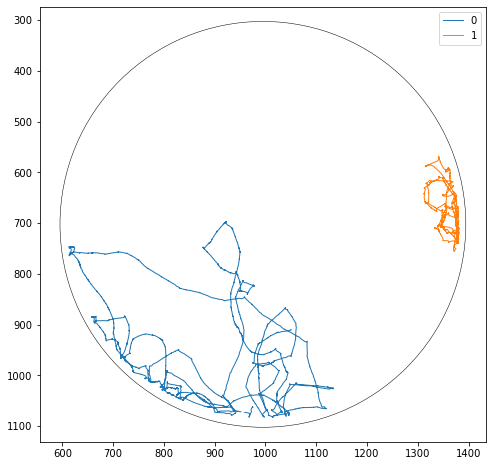

In [14]:
plt.figure(figsize=(8,)*2)
circle = plt.Circle( (tank.x_px,tank.y_px), tank.r_px,
                     facecolor='None', edgecolor='k', lw=0.5 )
plt.gca().add_patch(circle)
for fish in range(data.shape[1]):
    x,y,theta,area = data[:,fish].T
#         plt.plot(x,y,marker='o',ms=2,mew=0.5,mfc='None',lw=0,label=str(fish))
    plt.plot(x,y,lw=1,label=str(fish))
plt.axis('equal')
plt.gca().yaxis.set_inverted(True)
plt.legend()
plt.show()


# Compute spatial and kinematic quantities

In [5]:
globals().update(trial)

# Convert pixels to cm.
tank.r_cm = tank_diameter_vs_age[age]/2
a = tank.r_cm/tank.r_px
for i in range(n_ind):
    df[i,'x'] =  a*(df[i,'x_px']-tank.x_px)
    df[i,'y'] = -a*(df[i,'y_px']-tank.y_px)

fish = df.columns.levels[0]

for f in fish:
    
    df[f,'d_wall'] = tank.r_cm - np.hypot(df[f,'x'],df[f,'y'])
    
    df[f,'v_x']    = df[f,'x'].diff()*fps
    df[f,'v_y']    = df[f,'y'].diff()*fps
    df[f,'v']      = np.hypot(df[f,'v_x'],df[f,'v_y'])
    
    ang_diff       = df[f,'ang'].diff()
    ang_diff      -= 2*np.pi*np.rint(ang_diff/(2*np.pi))
    df[f,'v_ang']  = ang_diff*fps
    
# Reorder columns.
# df = df.sort_index(axis=1) # Sort alphabetically, which also sorts by fish.
columns = [ (f,q) for f in fish for q in ['x_px', 'y_px', 'area', 'ang', 'v_ang', 
                                          'x', 'y', 'v_x', 'v_y', 'v', 'd_wall'] ]
df = df.reindex(columns=columns)
display(df[:3])

0                                                   \
                x_px         y_px  area       ang     v_ang         x   
frame                                                                   
0.033333  974.187135  1062.342105  57.0  3.444877       NaN -0.248637   
0.066667  974.120944  1062.312684  56.5  3.441548 -0.099859 -0.249432   
0.100000  974.218391  1062.327586  58.0  3.443268  0.051590 -0.248262   
0.133333  974.491667  1062.400000  60.0  3.438944 -0.129732 -0.244981   
0.166667  974.218391  1062.327586  58.0  3.443268  0.129732 -0.248262   
...              ...          ...   ...       ...       ...       ...   
2.866667  967.384409  1081.720430  62.0  5.030351 -0.302823 -0.330311   
2.900000  967.512821  1081.256410  58.5  5.037551  0.215989 -0.328770   
2.933333  967.413223  1081.526171  60.5  5.040255  0.081117 -0.329965   
2.966667  967.346457  1081.635171  63.5  5.033889 -0.190971 -0.330767   
3.000000  967.216931  1081.693122  63.0  5.043296  0.282210 -0.332322   

                                                  ...           1        \
                 y       v_x       v_y         v  ...        y_px  area   
frame                                             ...                     
0.033333 -4.322353       NaN       NaN       NaN  ...  710.018315  45.5   
0.066667 -4.321999 -0.023841  0.010597  0.026090  ...  709.953405  46.5   
0.100000 -4.322178  0.035099 -0.005367  0.035507  ...  709.733333  45.0   
0.133333 -4.323048  0.098429 -0.026082  0.101826  ...  709.919540  43.5   
0.166667 -4.322178 -0.098429  0.026082  0.101826  ...  709.431373  42.5   
...            ...       ...       ...       ...  ...         ...   ...   
2.866667 -4.555010 -0.019365 -0.037761  0.042437  ...  709.654762  42.0   
2.900000 -4.549439  0.046252  0.167132  0.173414  ...  709.559387  43.5   
2.933333 -4.552678 -0.035873 -0.097163  0.103574  ...  709.662791  43.0   
2.966667 -4.553987 -0.024048 -0.039260  0.046040  ...  709.816479  44.5   
3.000000 -4.554683 -0.046653 -0.020873  0.051109  ...  709.706522  46.0   

                                                                      \
               ang     v_ang         x         y       v_x       v_y   
frame                                                                  
0.033333  1.586873       NaN  4.630275 -0.092320       NaN       NaN   
0.066667  1.608631  0.652745  4.629657 -0.091541 -0.018513  0.023379   
0.100000  1.611197  0.076986  4.629682 -0.088899  0.000732  0.079266   
0.133333  1.587967 -0.696909  4.630122 -0.091134  0.013202 -0.067069   
0.166667  1.606406  0.553184  4.630841 -0.085273  0.021561  0.175830   
...            ...       ...       ...       ...       ...       ...   
2.866667  1.580637 -0.344012  4.629879 -0.087955 -0.062369  0.042489   
2.900000  1.590670  0.300972  4.631318 -0.086810  0.043175  0.034352   
2.933333  1.589794 -0.026260  4.630663 -0.088052 -0.019641 -0.037244   
2.966667  1.613903  0.723250  4.629705 -0.089897 -0.028737 -0.055356   
3.000000  1.602357 -0.346369  4.630854 -0.088577  0.034473  0.039605   

                              
                 v    d_wall  
frame                         
0.033333       NaN  0.168805  
0.066667  0.029822  0.169438  
0.100000  0.079269  0.169465  
0.133333  0.068356  0.168981  
0.166667  0.177147  0.168374  
...            ...       ...  
2.866667  0.075467  0.169286  
2.900000  0.055174  0.167869  
2.933333  0.042106  0.168500  
2.966667  0.062371  0.169422  
3.000000  0.052506  0.168299  

[90 rows x 22 columns]

# Perform cuts

In [6]:
cut_ranges = { 'd_wall': [0,tank.r_cm], 
               'v':      [0,np.inf], 
               'v_ang':  [-np.inf,np.inf] }


# Locate fish/frame combinations that didn't make the cut(s).
cut_names = [ 'cut_'+q for q in cut_ranges.keys() ]
valid_fraction = {}
for f in fish:
    for q,(vmin,vmax) in cut_ranges.items():
        df[f,'cut_'+q]  = (df[f,q]>vmin) & (df[f,q]<vmax)
    df[f,'cut_final'] = df.loc[:,(f,cut_names)].all(axis=1)

    
# # For each fish, compute the fraction of points that made it through each cut.
# valid_fraction = {}
# for f in fish:
#     for c in list(cut_ranges.keys())+['final']:
#         valid_fraction[f,c] = df[f,'cut_'+c].mean()
# display(valid_fraction)

# Compute the fraction of points that made it through each cut.
valid_fraction = {}
for c in list(cut_ranges.keys())+['final']:
    B = [df[f,'cut_'+c] for f in fish]
    valid_fraction[c] = sum([b.sum() for b in B])/sum([len(b) for b in B])
display(valid_fraction)

# # Plot the fraction of points that made it through each cut.
# plt.bar(*zip(*valid_fraction.items()))
# plt.xlabel('Cut')
# plt.ylabel('Valid fraction')
# plt.show()


# Reorder columns.
columns = [ (f,q) for f in fish for q in ['x_px', 'y_px', 'area', 
                                          'ang', 'v_ang', 'cut_v_ang', 
                                          'x', 'y', 'v_x', 'v_y', 'v', 'cut_v', 
                                          'd_wall', 'cut_d_wall', 
                                          'cut_final'] ]
df  = df.reindex(columns=columns)
df0 = df.copy()
# display(df0[:5])


# Create a filtered dataframe.
cols = ['ang', 'v_ang', 'x', 'y', 'v_x', 'v_y', 'v', 'd_wall']
df   = df0.loc[:,(slice(None),cols)].copy()
for f in fish:
    df.loc[~df0[f,'cut_final'],f] = np.nan
display(df[:3])

{'d_wall': 0.99998552403011,
 'v': 0.9556311522872032,
 'v_ang': 0.99994209612044,
 'final': 0.9556311522872032}

0                                                    \
               ang     v_ang         x         y       v_x       v_y   
frame                                                                  
0.033333       NaN       NaN       NaN       NaN       NaN       NaN   
0.066667  3.441548 -0.099859 -0.249432 -4.321999 -0.023841  0.010597   
0.100000  3.443268  0.051590 -0.248262 -4.322178  0.035099 -0.005367   
0.133333  3.438944 -0.129732 -0.244981 -4.323048  0.098429 -0.026082   
0.166667  3.443268  0.129732 -0.248262 -4.322178 -0.098429  0.026082   
...            ...       ...       ...       ...       ...       ...   
2.866667  5.030351 -0.302823 -0.330311 -4.555010 -0.019365 -0.037761   
2.900000  5.037551  0.215989 -0.328770 -4.549439  0.046252  0.167132   
2.933333  5.040255  0.081117 -0.329965 -4.552678 -0.035873 -0.097163   
2.966667  5.033889 -0.190971 -0.330767 -4.553987 -0.024048 -0.039260   
3.000000  5.043296  0.282210 -0.332322 -4.554683 -0.046653 -0.020873   

                                     1                                \
                 v    d_wall       ang     v_ang         x         y   
frame                                                                  
0.033333       NaN       NaN       NaN       NaN       NaN       NaN   
0.066667  0.026090  0.470809  1.608631  0.652745  4.629657 -0.091541   
0.100000  0.035507  0.470698  1.611197  0.076986  4.629682 -0.088899   
0.133333  0.101826  0.470017  1.587967 -0.696909  4.630122 -0.091134   
0.166667  0.101826  0.470698  1.606406  0.553184  4.630841 -0.085273   
...            ...       ...       ...       ...       ...       ...   
2.866667  0.042437  0.233029  1.580637 -0.344012  4.629879 -0.087955   
2.900000  0.173414  0.238697  1.590670  0.300972  4.631318 -0.086810   
2.933333  0.103574  0.235380  1.589794 -0.026260  4.630663 -0.088052   
2.966667  0.046040  0.234017  1.613903  0.723250  4.629705 -0.089897   
3.000000  0.051109  0.233210  1.602357 -0.346369  4.630854 -0.088577   

                                                  
               v_x       v_y         v    d_wall  
frame                                             
0.033333       NaN       NaN       NaN       NaN  
0.066667 -0.018513  0.023379  0.029822  0.169438  
0.100000  0.000732  0.079266  0.079269  0.169465  
0.133333  0.013202 -0.067069  0.068356  0.168981  
0.166667  0.021561  0.175830  0.177147  0.168374  
...            ...       ...       ...       ...  
2.866667 -0.062369  0.042489  0.075467  0.169286  
2.900000  0.043175  0.034352  0.055174  0.167869  
2.933333 -0.019641 -0.037244  0.042106  0.168500  
2.966667 -0.028737 -0.055356  0.062371  0.169422  
3.000000  0.034473  0.039605  0.052506  0.168299  

[90 rows x 16 columns]

# Compute and plot distributions

TODO: Compute histogram for each fish, then use the standard error as the uncertainty on the distribution.

### Distance to the wall

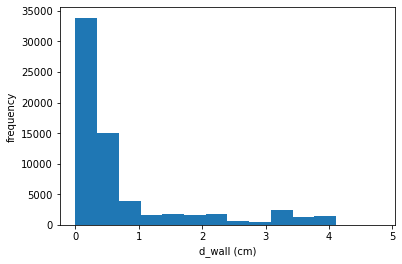

In [7]:
quantity = 'd_wall'
unit = 'cm'
bins = np.linspace(0,tank.r_cm,15)

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.show()

### Velocity

/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


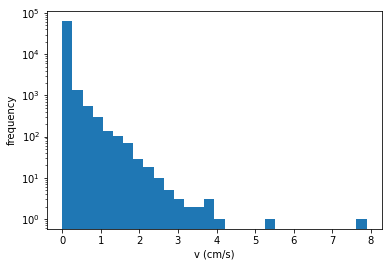

In [8]:
quantity = 'v'
unit = 'cm/s'
bins = 30

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [9]:
# fast = df.loc[:,(slice(None),'v')]>6
# print(np.nonzero(fast.values))
# display(df.iloc[266:269][4])

### Angular velocity

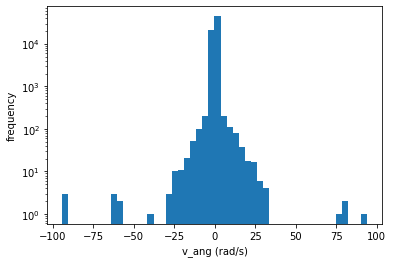

In [10]:
quantity = 'v_ang'
unit = 'rad/s'
bins = 50

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [11]:
# At 30 fps, |v_ang|=30 (about where the rare peaks start) 
# corresponds to about pi/3 in one frame.
print('v_ang for pi/3 in (1/30) second:',np.pi/3*fps)

print('Instances of unusually high v_ang:')
for f in fish:
    ang_diff  = df[f,'ang'].diff()
    ang_diff -= 2*np.pi*np.rint(ang_diff/(2*np.pi))
    I = np.nonzero(np.absolute(ang_diff.values)>1)[0]
    for i in I:
        display(df[f,'ang'][i-1:i+2])

v_ang for pi/3 in (1/30) second: 31.415926535897928
Instances of unusually high v_ang:


/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


frame
91.000000    10.026013
91.033333    10.009574
91.066667    10.013569
91.100000    10.009031
91.133333    10.005035
               ...    
93.866667    10.216429
93.900000    10.202921
93.933333    10.211789
93.966667    10.202921
94.000000    10.206865
Name: (0, ang), Length: 91, dtype: float64

frame
242.000000    13.927987
242.033333    13.946729
242.066667    13.938870
242.100000    13.931010
242.133333    13.913664
                ...    
244.866667    13.931019
244.900000    13.934057
244.933333    13.944279
244.966667    13.945116
245.000000    13.944072
Name: (0, ang), Length: 91, dtype: float64

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (0, ang), dtype: float64)

Series([], Name: (1, ang), dtype: float64)

Series([], Name: (1, ang), dtype: float64)

Series([], Name: (1, ang), dtype: float64)

Series([], Name: (1, ang), dtype: float64)

### Pair distance-pair angle distribution

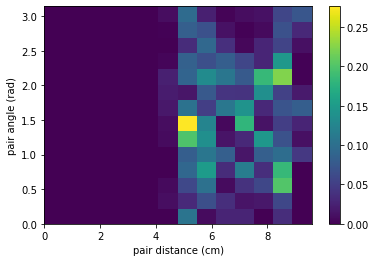

In [12]:
bins_d = np.linspace(0,2*tank.r_cm,15)
bins_a = np.linspace(0,np.pi,15)
H      = [] # np.zeros((len(bins_d)-1,len(bins_a)-1))
for f1,f2 in itertools.combinations(fish,2):
#     print(f1,f2)
    d = np.hypot(df[f1,'x']-df[f2,'x'],df[f1,'y']-df[f2,'y'])
    a = df[f1,'ang']-df[f2,'ang']
    a = np.absolute(a - 2*np.pi*np.rint(a/(2*np.pi)))
    h,_,_ = np.histogram2d(d,a,bins=(bins_d,bins_a),normed=True)
    H.append(h)

H   = np.mean(H,axis=0)
plt.pcolormesh(bins_d,bins_a,H.T)
plt.xlabel('pair distance (cm)')
plt.ylabel('pair angle (rad)')
plt.colorbar()
plt.show()

# Angular dynamics

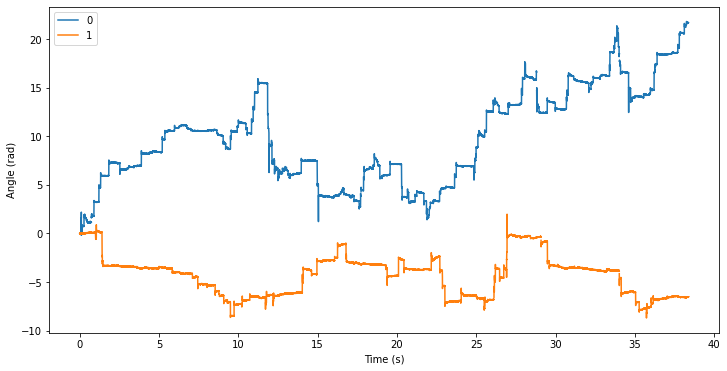

In [13]:
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib inline

plt.figure(figsize=(12,6))
for f in fish:

    ang  = df[f,'ang']
    t    = ang.index/fps
    
    dang = ang.diff()
    dang = dang - 2*np.pi*np.rint(dang/(2*np.pi))
    ang  = np.cumsum(dang)

#     I = (t>297) & (t<301)
#     t,th = t[I],th[I]

    plt.plot(t,ang,label=f) #,marker='.')

plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
# plt.savefig(trial.make_fig_file('angle-vs-time',''),**trial.plot_options)
plt.legend()
plt.show()